In [55]:
import pandas as pd

df_dance = pd.read_csv('../data/dataset_0.csv')
df_idle = pd.read_csv('../data/dataset_1.csv')
df_walk = pd.read_csv('../data/dataset_2.csv')
df_run = pd.read_csv('../data/dataset_3.csv')
df_spin = pd.read_csv('../data/dataset_4.csv')

In [56]:
df = pd.concat([df_dance, df_idle, df_walk, df_run, df_spin])
df.rename(columns={'Set': 'Label'}, inplace=True)
df.drop(columns=['OrientationX_sin', 'OrientationX_cos', 'OrientationY_sin', 'OrientationY_cos', 'OrientationZ_sin', 'OrientationZ_cos'], inplace=True) #Let´s try to use only accelerometer and gyroscope at least for now

In [57]:
df.describe()

,AnimIndex,AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ
count,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000,100885.000000
mean,22.773296,0.512160,0.602361,-13.880446,0.021490,-0.134352,0.027093
std,13.720834,351.392805,80.974049,725.671497,1.952378,3.457387,3.041067
min,0.000000,-12158.802680,-3558.359820,-20438.724145,-69.101625,-137.498576,-157.101248
25%,11.000000,-5.383237,-4.924168,-38.912660,-0.159503,-0.219591,-0.138246
50%,23.000000,0.001952,-0.018100,-0.196599,-0.004404,-0.004562,0.004975
75%,33.000000,5.571368,4.750234,1.819372,0.143643,0.177220,0.158001
max,53.000000,12075.459636,3520.777847,20343.089371,74.797051,125.485251,156.235443


In [58]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [59]:
import numpy as np

def create_sliding_windows(data, label_col, window_size, step_size):
    sequences = []
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        sequences.append(window[feature_cols].values)
        label = window[label_col].mode()[0]
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 100
step_size = 25
X, y = create_sliding_windows(df, label_col='Label', window_size=window_size, step_size=step_size)

In [60]:
from sklearn.model_selection import train_test_split

train_indices, temp_indices = train_test_split(df['AnimIndex'].unique(), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_data = df[df['AnimIndex'].isin(train_indices)]
val_data = df[df['AnimIndex'].isin(val_indices)]
test_data = df[df['AnimIndex'].isin(test_indices)]

X_train, y_train = create_sliding_windows(train_data, label_col='Label', window_size=window_size, step_size=step_size)
X_val, y_val = create_sliding_windows(val_data, label_col='Label', window_size=window_size, step_size=step_size)
X_test, y_test = create_sliding_windows(test_data, label_col='Label', window_size=window_size, step_size=step_size)

In [61]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [62]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(window_size, len(feature_cols)), return_sequences=False),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18176     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 22,661
Trainable params: 22,661
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
44/44 [==============================] - 3s 44ms/step - loss: 1.4729 - accuracy: 0.4071 - val_loss: 1.1752 - val_accuracy: 0.5943
Epoch 2/100
44/44 [==============================] - 2s 37ms/step - loss: 1.0929 - accuracy: 0.5757 - val_loss: 0.9368 - val_accuracy: 0.6778
Epoch 3/100
44/44 [==============================] - 2s 37ms/step - loss: 1.0003 - accuracy: 0.6126 - val_loss: 0.9669 - val_accuracy: 0.6110
Epoch 4/100
44/44 [==============================] - 2s 37ms/step - loss: 0.9089 - accuracy: 0.6420 - val_loss: 0.7240 - val_accuracy: 0.7245
Epoch 5/100
44/44 [==============================] - 2s 36ms/step - loss: 0.7839 - accuracy: 0.6992 - val_loss: 0.6509 - val_accuracy: 0.7696
Epoch 6/100
44/44 [==============================] - 2s 36ms/step - loss: 0.7244 - accuracy: 0.7275 - val_loss: 0.6097 - val_accuracy: 0.8047
Epoch 7/100
44/44 [==============================] - 2s 36ms/step - loss: 0.6819 - accuracy: 0.7444 - val_loss: 0.5592 - val_accuracy: 0.8447
Epoch 

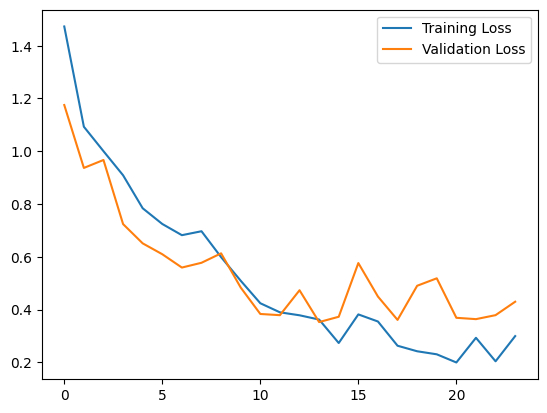

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [66]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

20/20 [==============================] - 0s 10ms/step - loss: 0.9969 - accuracy: 0.7093
Test Loss: 0.9969, Test Accuracy: 0.7093


In [68]:
model.save('../models/imu_rnn_classifier.keras')